In [1]:
import tensorflow as tf
import numpy as np
import os
from utils import *
from sklearn.preprocessing import MultiLabelBinarizer
import datetime
import pandas as pd

from tensorflow.python.saved_model import tag_constants


import tensorflow.contrib.slim as slim

from apc import AveragePrecisionCalculator

import matplotlib.pyplot as plt

/home/ec2-user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import hashlib
import itertools
import json
import os
from six.moves import urllib
import sys

In [3]:
tf.reset_default_graph()

In [4]:
# INIT
sess = tf.Session()
#sess.run(tf.global_variables_initializer())

In [10]:
# LOAD GRAPH
directory  = '/home/ec2-user/Notebooks/Models/MyModel/'
lossplt_dir = directory + 'loss_plt.txt'
export_dir = directory + 'Model/'
l = tf.saved_model.loader.load(sess, 
                           ['tag'],#[tag_constants.SERVING], 
                           export_dir)

INFO:tensorflow:Restoring parameters from /home/ec2-user/Notebooks/Models/MyModel/Model/variables/variables


In [7]:
graph = tf.get_default_graph()
X = graph.get_tensor_by_name("X:0")
Y = graph.get_tensor_by_name("Y:0")
keep_prob = graph.get_tensor_by_name("keep_prob:0")
pred = graph.get_tensor_by_name("pred/add:0")

In [9]:
#EVALUATE
one_hot = MultiLabelBinarizer(classes=[i for i in range(3862)])

datadir = '/home/ec2-user/data/yt8m/validate/'
APC = AveragePrecisionCalculator()
appp = []
for file in os.listdir(datadir)[:30]:
    if file[-5:]=='.json':
        continue
    filename = datadir + file    
    vid_ids, labels, mean_rgb, mean_audio = get_data_from_file(filename)

    onehot_labels = one_hot.fit_transform(labels)
    #onehot_labels = onehot_labels[:,:869]
    
    b = BatchIterator(onehot_labels, mean_rgb,mean_audio)
    
    p = sess.run(tf.sigmoid(pred), feed_dict={X: b.x, Y: b.y, keep_prob:1.0})

    ap = 0
    for i in range(p.shape[0]):
        ap+=APC.ap(p[i], b.y[i])

    ap_avg = ap/p.shape[0]
    print(ap_avg)
    appp.append(ap_avg)
print('average: {}'.format(np.mean(ap_avg)))

0.7546689463502535
0.7606386383605344
0.7673577467501961
0.7513017085154895
0.7424661350740835
0.763270734209005
0.7589331997715478
0.7734387781705189
0.7807759786727898
0.7363339565337271
0.7716533161554042
0.751484272021888
0.7626812909264085
0.7451329346060096
0.7362958793189256
0.7651285082975754
0.7696605355682234
0.7583024600143494
0.7611743112309411
0.7416169993302313
0.7246782979119804
0.7733418700679122
0.7417297661079121
0.7531113069703033
0.7423286826575162
0.7903498639095039
0.7757345055589252
0.7616411518095122
0.7494746349423886
average: 0.7494746349423886


In [17]:
with open(lossplt_dir, 'r') as file:
    lp = file.read()

In [18]:
ls= eval(lp)

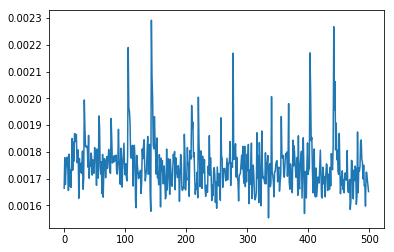

In [23]:
plt.plot(ls[500:])

In [ ]:
tf.saved_model.loader.load(
    sess,
    [tag_constants.SERVING],
    '/home/ec2-user/Notebooks/MyModel/'
)
#X = tf.get_default_graph().get_tensor_by_name('X')


In [ ]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
#[n.name for n in tf.get_default_graph().as_graph_def().node]


In [ ]:
tf.global_variables()

In [ ]:
XXX = tf.get_default_graph().get_tensor_by_name('conv_1/w:0')


In [ ]:
# LOAD

graph = tf.Graph()
with graph.as_default():    
    with tf.Session() as sess:
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            '/home/ec2-user/Notebooks/MyModel3/'
        )
        sess.run(X, feed_dict={X:np.zeros([10,1024+128])})



In [ ]:
X = tf.get_default_graph().get_tensor_by_name('X:0')
        

In [ ]:
tf.graph

In [ ]:
plt.plot(loss_plt[300:])

In [ ]:
plt.plot(loss_plt[50:])

In [ ]:
np.mean(loss_plt)

# TRAIN
one_hot = MultiLabelBinarizer(classes=[i for i in range(3862)])
datadir = '/home/ec2-user/data/yt8m/train/'

# Iterate through train directory
for file in os.listdir(datadir)[:13]:
    if file[-5:]=='.json':
        continue
    filename = datadir + file
    vid_ids, labels, mean_rgb, mean_audio = get_data_from_file(filename)

    onehot_labels = one_hot.fit_transform(labels)
    #onehot_labels = onehot_labels[:,:ydim]
    
    b = BatchIterator(onehot_labels, mean_rgb,mean_audio)
    # TRAIN
    for i in range(1001):
        batch = b.next_batch(32)
        if i % 500 == 0:
            loss = sess.run(mloss, feed_dict={X: batch[0], Y: batch[1], keep_prob:1.0})
            print('step %d, loss %g' % (i, loss))
        sess.run(train, feed_dict={X: batch[0], Y: batch[1], keep_prob:0.5})

    print('')
    
    
    # print('test accuracy %g' % sess.run(accuracy, 
    #                                     feed_dict={X: mnist.test.images, y_: mnist.test.labels}))


In [ ]:
#EVALUATE
datadir = '/home/ec2-user/data/yt8m/validate/'
APC = AveragePrecisionCalculator()
appp = []
for file in os.listdir(datadir)[:20]:
    if file[-5:]=='.json':
        continue
    filename = datadir + file    
    vid_ids, labels, mean_rgb, mean_audio = get_data_from_file(filename)

    onehot_labels = one_hot.fit_transform(labels)
    #onehot_labels = onehot_labels[:,:869]
    
    b = BatchIterator(onehot_labels, mean_rgb,mean_audio)
    
    p = sess.run(tf.sigmoid(pred), feed_dict={X: b.x, Y: b.y, keep_prob:1.0})

    ap = 0
    for i in range(p.shape[0]):
        ap+=APC.ap(p[i], b.y[i])

    ap_avg = ap/p.shape[0]
    print(ap_avg)
    appp.append(ap_avg)
print('average: {}'.format(np.mean(ap_avg)))

#INFER
datadir = '/home/ec2-user/data/yt8m/test/'
outfile = 'out/'+ str(datetime.datetime.now())+'.csv'
with open(outfile, 'w') as f:
    pd.DataFrame(columns=['VideoIds','LabelConfidencePairs']).to_csv(f, index=False)
    
for file in os.listdir(datadir)[:3]:
    if file[-5:]=='.json':
        continue
    filename = datadir + file

    print(file)
    
    vid_ids, _, mean_rgb, mean_audio = get_data_from_file(filename,has_labels=False)
    
    fake_labels = [[1] for _ in range(len(mean_rgb))]
    
    b = BatchIterator(fake_labels, mean_rgb,mean_audio)
    
    p = sess.run(tf.sigmoid(pred), feed_dict={X: b.x, keep_prob:1.0})
    
    top20 = p.argsort(axis=-1)[:,-20:][:,::-1]
    x_axis_index=np.tile(np.arange(len(p)), (top20.shape[1],1)).transpose() 
    probs = p[x_axis_index, top20]
    
    idx_probs = np.stack([top20, probs], axis=-1)
    idx_probs = [[(int(idx_probs[i,j,0]), idx_probs[i,j,1]) for j in range(idx_probs.shape[1])] for i in range(idx_probs.shape[0])]
    
    out = [str(idx_probs[0]).replace('[', '').replace(']', '').replace('(', '').replace(')', '').replace(',', '') for i in range(len(idx_probs))]
    
    df = pd.DataFrame(data={'VideoId':vid_ids, 'LabelConfidencePairs':out})
    with open(outfile, 'a') as f:
        df.to_csv(f, header=False, index=False)
    
    
    

In [ ]:
datadir = '/home/ec2-user/data/yt8m/test/'
tempfile = '/home/ec2-user/data/yt8m/test_all/xx.tfrecord'
outfile = 'out/'+ str(datetime.datetime.now())+'.csv'

with open(outfile, 'w') as f:
    pd.DataFrame(columns=['VideoId','LabelConfidencePairs']).to_csv(f, index=False)
    
mirror = 'us'
partition = '2/video/test'
partition_parts = partition.split('/')
plan_url = 'http://data.yt8m.org/{}/download_plans/{}_{}.json'.format(
      partition_parts[0], partition_parts[1], partition_parts[2])
download_plan = json.loads(urllib.request.urlopen(plan_url).read())
files = [f for f in download_plan['files'].keys()]

ct = 0
start = datetime.datetime.now()
for f in files:
    ct+=1
    print('starting file {} of {}'.format(ct, len(files)))
    print('its been this much time: {}'.format(datetime.datetime.now()-start))
    print('{} % done'.format(int(ct/len(files)*100)))
    try:
        print('estimated time remaining {}'.format( (datetime.datetime.now()-start)/ ((ct-1)/(len(files)-(ct-1))) ))
    except:
        pass
    print(f)
    
    download_url = 'http://%s.data.yt8m.org/%s/%s' % (mirror, partition, f)
    download_file(download_url, tempfile)
    
    vid_ids, _, mean_rgb, mean_audio = get_data_from_file(tempfile, has_labels=False)
    
    fake_labels = [[1] for _ in range(len(mean_rgb))]
    b = BatchIterator(fake_labels, mean_rgb,mean_audio)
    
    p = sess.run(tf.sigmoid(pred), feed_dict={X: b.x, keep_prob:1.0})
    
    top20 = p.argsort(axis=-1)[:,-20:][:,::-1]
    x_axis_index=np.tile(np.arange(len(p)), (top20.shape[1],1)).transpose() 
    probs = p[x_axis_index, top20]
    idx_probs = np.stack([top20, probs], axis=-1)
    idx_probs = [[(int(idx_probs[i,j,0]), idx_probs[i,j,1]) for j in range(idx_probs.shape[1])] for i in range(idx_probs.shape[0])]
    out = [str(idx_probs[i]).replace('[', '').replace(']', '').replace('(', '').replace(')', '').replace(',', '') for i in range(len(idx_probs))]
    df = pd.DataFrame(data={'VideoId':vid_ids, 'LabelConfidencePairs':out})
    
    with open(outfile, 'a') as f:
        df.to_csv(f, header=False, index=False)

In [ ]:
p = sess.run(tf.sigmoid(pred), feed_dict={X: b.x, Y: b.y})

predicted = one_hot.inverse_transform(np.concatenate([np.array(p>.5, dtype=int), np.zeros([292,3862-869])], axis=1))
actual = one_hot.inverse_transform(np.concatenate([b.y, np.zeros([292,3862-869])], axis=1))




In [ ]:
correct=0

for i in range(len(actual)):
    if actual[i]==predicted[i]:
        correct+=1
print(correct/len(actual))

In [ ]:
actual[0]==predicted[0]

In [ ]:
actual

In [ ]:
predicted

In [ ]:
p.shape

In [ ]:
one_hot.inverse_transform(np.concatenate([batch[1], np.zeros([32,3862-869])], axis=1))

In [ ]:
one_hot.classes[:869][batch[1][0]>.5]

In [ ]:
one_hot.classes

In [ ]:
np.zeros(2)[[True,False]]

In [ ]:
datadir = '/home/ec2-user/data/yt8m/test/'

In [ ]:
file=os.listdir(datadir)[5]
filename = datadir + file
for example in tf.python_io.tf_record_iterator(filename):
    tf_example = tf.train.Example.FromString(example)
    vid_ids, labels, mean_rgb, mean_audio = get_data_from_file(filename)

In [ ]:
def get_data_from_file(filename, has_labels=True):
    vid_ids, labels, mean_rgb, mean_audio = [], [], [], []

    for example in tf.python_io.tf_record_iterator(filename):
        tf_example = tf.train.Example.FromString(example)

        vid_ids.append(tf_example.features.feature['id'].bytes_list.value[0].decode(encoding='UTF-8'))
        labels.append(tf_example.features.feature['labels'].int64_list.value)
        mean_rgb.append(tf_example.features.feature['mean_rgb'].float_list.value)
        mean_audio.append(tf_example.features.feature['mean_audio'].float_list.value)
    return vid_ids, labels, mean_rgb, mean_audio

In [ ]:
labels[-1]

In [ ]:
tf_example

In [ ]:
p = sess.run(tf.sigmoid(pred),
        feed_dict={X: batch[0], Y: batch[1]})

In [ ]:
np.sum(p>.5, axis=1)

In [ ]:
one_hot.classes_[p[6]>.5]

In [ ]:
yy = batch[1][6]

In [ ]:
one_hot.classes_[yy>.5]

In [ ]:
yy

In [ ]:
import apc_file

In [ ]:
apcc = apc_file.AveragePrecisionCalculator()

In [ ]:
apcc.ap(p[2], b.y[2])

In [ ]:
p